# Synthetic Faces and Exploration of Latent Space



Code adapted from [Mikael Christensen](https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH), and [NVLabs](https://github.com/NVlabs/stylegan).
Refer to the work of [Denis Malimonov](https://colab.research.google.com/github/tg-bomze/StyleGAN2-Face-Modificator/blob/master/Face_Modificator_with_StyleGAN2_(Eng).ipynb) for getting latent vectors of custom images (real images) and then manipulating them. 

### Starter Code

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-5d696db0-a2e2-b6f4-5739-0c81605657a8)
GPU Identified at: /device:GPU:0


In [ ]:
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

### Generation of Synthetic Faces

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.7), 0.7 , 3))

Output hidden; open in https://colab.research.google.com to view.


### Face Interpolation

In [ ]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289 , 9148088 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.4 , 3))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613])

number_of_steps = 10
imgs = generate_images(interpolate(zs,number_of_steps), 0.7)

# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

In [ ]:
# more complex example, interpolating in W instead of Z space.
zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613 ])

# It seems my truncation_psi is slightly less efficient in W space - I probably introduced an error somewhere...

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=0.7))

number_of_steps = 10

imgs = generate_images_in_w_space(interpolate(dls,number_of_steps), 0.7)

%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

mkdir: cannot create directory ‘out’: File exists


### Arithmetic of Faces

In [ ]:
smiling_faces=[98,103,100]
z_smiling=generate_zs_from_seeds(smiling_faces)
latent_smiling=sum(z_smiling)/len(z_smiling)

In [ ]:
neutral_faces=[104,310,321]
z_neutral=generate_zs_from_seeds(neutral_faces)
latent_neutral=sum(z_neutral)/len(z_neutral)

In [ ]:
man_faces=[49,402,420]
z_man=generate_zs_from_seeds(man_faces)
latent_man=sum(z_man)/len(z_man)

In [ ]:
difference_latent=1.0*latent_smiling-1.0*latent_neutral
add_latent=1.0*difference_latent+1.0*latent_man

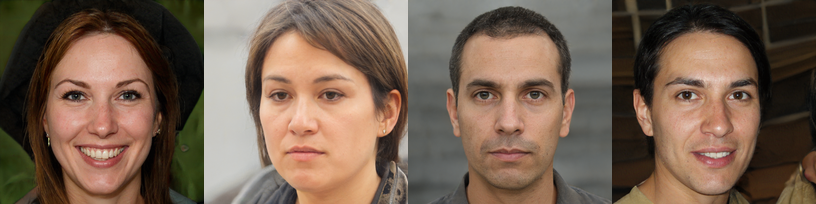

In [ ]:
zs=[latent_smiling,latent_neutral,latent_man,add_latent]
imgs=generate_images(zs, 0.5)
imshow(createImageGrid(imgs, 0.2 , 1))

### Attribute Manipulation

In [ ]:
%%capture
!wget https://hostb.org/NCM/stylegan2directions.zip

In [ ]:
%%capture
!unzip stylegan2directions.zip

In [ ]:
import numpy as np
attribute='age' #choose from ['age','eye_distance','eye_eyebrow_distance','eye_ratio','gender','lip_ratio','mouth_open','mouth_ratio','nose_mouth_distance','nose_ratio','nose_tip','pitch','roll','smile','yaw']
direction = np.load('stylegan2directions/'+attribute+'.npy')

In [ ]:
print(direction.shape)
print(type(direction))

(18, 512)
<class 'numpy.ndarray'>


In [ ]:
zs = generate_zs_from_seeds([1])
dls = []
dls.append(convertZtoW(zs[0] ,truncation_psi=0.5))

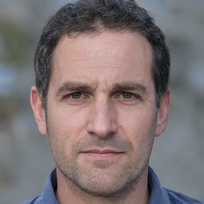

In [ ]:
imgs = generate_images_in_w_space(dls, 0.5)
imshow(createImageGrid(imgs, 0.2 , 1))

In [ ]:
dls[0]=dls[0].reshape((18,512))

In [ ]:
coeffs=[-5.0,-2.5,0.0,2.5,5.0]

In [ ]:
dls_new=[]
for coeff in coeffs:
  dl_new=dls[0].copy()
  dl_new[:8]=(dls[0]+coeff*direction)[:8]
  dls_new.append(dl_new.reshape((1,18,512)))

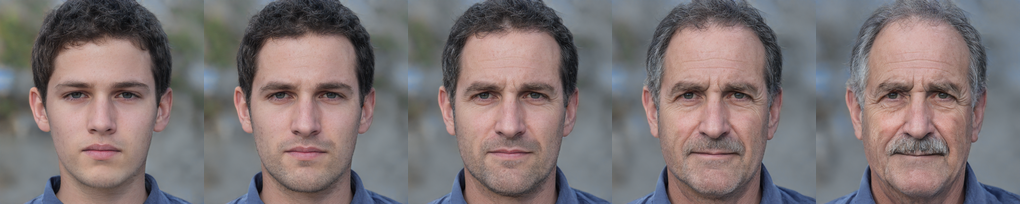

In [ ]:
imgs = generate_images_in_w_space(dls_new, 0.5)
imshow(createImageGrid(imgs, 0.2 , 1))